In [12]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from neuron import PyramidalCells
from scipy.stats import pearsonr

In [13]:
ENVIRONMENTS_RUNS = {
    # "F1": {'new_env': False, 'top_down': False, 'a': 0},
    "F2": {'new_env': False, 'top_down': False},
    "N1": {'new_env': True,  'top_down': False},
    "F3": {'new_env': False, 'top_down': True}, 
    "N2_0": {'new_env': True,  'top_down': True},
    "N2_1": {'new_env': True,  'top_down': True}, ## I added this to double the length of N2
    "N2_2": {'new_env': True,  'top_down': True},
    }

def get_activation_map(firing_rates, m_EC, x_run_reshaped, n_bins = 64):
    sort_TD = np.argsort(m_EC)
    sorted_fr = firing_rates[np.ix_(sort_TD, np.arange(firing_rates.shape[1]))]

    bins = np.arange(n_bins)
    n_cell = np.arange(sorted_fr.shape[0])
    out_collector = {k : [] for k in product(n_cell, bins)}
    out = np.zeros((sorted_fr.shape[0], n_bins))
    position_bins = np.linspace(0, x_run_reshaped.max(), n_bins)

    for idx, pos in enumerate(x_run_reshaped):
        bin_idx = np.argmin(np.abs(position_bins - pos))

        for i in range(sorted_fr.shape[0]):
            out_collector[(i, bin_idx)].append(sorted_fr[i, idx])

    for k, v in out_collector.items():
        out[k] = np.mean(v)

    return out


def simulate_run(len_track = 200, av_running_speed = 20, dt = 0.01, tn = 1000):
    ## TODO: Does it need to be this long?
    bins = np.arange(0., len_track)
    fps = 1/dt
    n_runs = int(2*tn/(len_track/av_running_speed))

    x = np.array([])
    i = 0
    while True:
        stopping_time = np.random.uniform(0, 1, 2)
        stop1 = np.ones((int(stopping_time[0]*fps),)) * 0.
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time[1]*fps),)) * (len(bins)-1.)
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
        if len(x) >= tn*fps:
            break
        i += 1

    x = x[:int(tn*fps)]
    t = np.arange(len(x))/fps

    return t, x


def get_firing_rates(pyramidal, event_count, x_run):

    print('Event count shape:', event_count.shape)
    firing_rates = np.zeros((event_count.shape[1], 1024))
    x_run_reshaped = np.zeros(1024)
    step_size = len(event_count)//firing_rates.shape[1]
    
    for i in range(firing_rates.shape[1]):
        firing_rates[:, i] = np.sum(event_count[i * step_size:(i + 1) * step_size, :], axis = 0) / (step_size*pyramidal.dt)
        x_run_reshaped[i] = np.mean(x_run[i * step_size:(i + 1) * step_size])

    return firing_rates, x_run_reshaped


def cor_act_maps(act_map1, act_map2):
    cor = np.zeros(act_map1.shape[0])
    for i in range(act_map1.shape[0]):
        cor[i] = pearsonr(act_map1[i, :], act_map2[i, :])[0]

    return cor.mean()


def get_start_idxs(x_run):
    start_idxs = np.where(x_run == 0)[0]

    st_idxs_use = []
    memory = 0 

    for idx in range(len(start_idxs)):

        if start_idxs[idx] != memory + 1:
            st_idxs_use.append(start_idxs[idx])
        memory = start_idxs[idx]

    return st_idxs_use


def plot_firing_rates(fig, ax, mean_firing_rates, out):

    extent = [0, 100, 0, mean_firing_rates.shape[0]]
    im = ax.imshow(mean_firing_rates, aspect='auto', extent=extent, origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title(f"{out}")
    ax.set_xlabel("Position (cm)")
    ax.set_ylabel("Neuron")

    return fig, ax

In [14]:

lr = 10
t_epoch = 1
speed = 20
len_track = 100. 
dt = 0.001
tn = len_track/speed*32
a = 0.3 # 1 - similarity between environments
n_cells = {'pyramidal' : 200, 'inter_a' : 20, 'inter_b' : 20, 'CA3' : 120}

pyramidal = PyramidalCells(n_cells, weights = dict(), learning_rate = lr, dt = dt)
pyramidal.alpha = 0.0125

t_run, x_run = simulate_run(len_track, speed, dt, tn)

st_idxs = get_start_idxs(x_run)




In [15]:

print('F1')

event_count, burst_count = pyramidal.learn_place_cells(t_run, x_run, t_epoch)


F1


(200, 64)


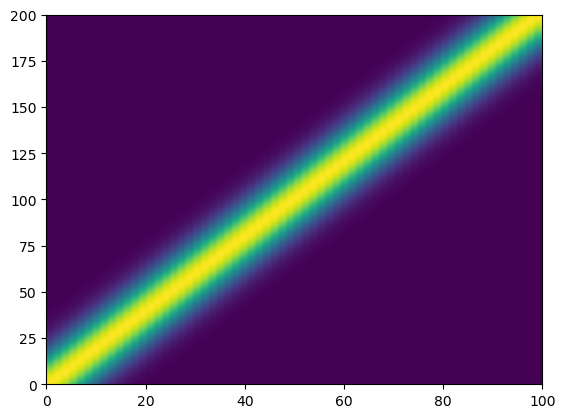

Event count shape: (10739, 200)
Event count shape: (9532, 200)
Event count shape: (9884, 200)
Event count shape: (12316, 200)
Event count shape: (12617, 200)
Event count shape: (13129, 200)
Event count shape: (11343, 200)
Event count shape: (10281, 200)
Event count shape: (12390, 200)
Event count shape: (12373, 200)
Event count shape: (11120, 200)
Event count shape: (11924, 200)
Event count shape: (10826, 200)


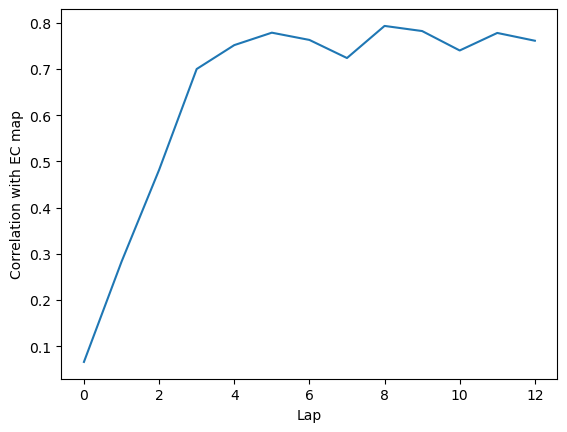

In [16]:
m_EC_orig, m_CA3_orig = pyramidal.m_EC, pyramidal.m_CA3

fr_EC = get_activation_map(pyramidal.full_EC_activities.T, m_EC_orig, x_run)

print(fr_EC.shape)

plt.figure()
plt.imshow(fr_EC, aspect='auto', extent=[0, 100, 0, fr_EC.shape[0]], origin='lower')
plt.show()

cors = []

for i in range(len(st_idxs) - 1):
    start, stop = st_idxs[i], st_idxs[i + 1]
    event_count_lap = event_count[start:stop, :]
    fr, x_run_reshaped = get_firing_rates(pyramidal, event_count_lap, x_run[start:stop])
    
    mean_firing_rates = get_activation_map(fr, m_EC_orig, x_run_reshaped)

    cors.append(cor_act_maps(fr_EC, mean_firing_rates))

    # plt.figure()
    # plt.imshow(mean_firing_rates, aspect='auto', extent=[0, 100, 0, mean_firing_rates.shape[0]], origin='lower')
    # plt.show()

plt.figure()
plt.plot(cors)
plt.xlabel('Lap')
plt.ylabel('Correlation with EC map')
plt.show()


Event count shape: (160000, 200)
Event count shape: (160000, 200)
F2


Event count shape: (160000, 200)
Event count shape: (160000, 200)
(200, 1024) (1024,)
N1
Event count shape: (160000, 200)
Event count shape: (160000, 200)
(200, 1024) (1024,)
F3
Event count shape: (160000, 200)
Event count shape: (160000, 200)
(200, 1024) (1024,)
N2_0
Event count shape: (160000, 200)
Event count shape: (160000, 200)
(200, 1024) (1024,)
Event count shape: (10739, 200)
Event count shape: (9532, 200)
Event count shape: (9884, 200)
Event count shape: (12316, 200)
Event count shape: (12617, 200)
Event count shape: (13129, 200)
Event count shape: (11343, 200)
Event count shape: (10281, 200)
Event count shape: (12390, 200)
Event count shape: (12373, 200)
Event count shape: (11120, 200)
Event count shape: (11924, 200)
Event count shape: (10826, 200)
N2_1
Event count shape: (160000, 200)
Event count shape: (160000, 200)
(200, 1024) (1024,)
Event count shape: (10739, 200)
Event count shape: (9532, 200)
Event count shape: (9884, 200)
Event count shape: (12316, 200)
Event count sh

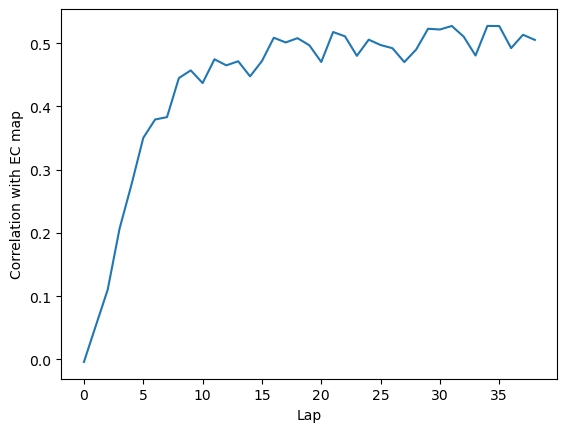

In [17]:

fr, x_run_reshaped = get_firing_rates(pyramidal, event_count, x_run)
m_EC_orig, m_CA3_orig = pyramidal.m_EC, pyramidal.m_CA3

br, _ = get_firing_rates(pyramidal, burst_count, x_run)

activation_maps = {}
burst_rates = {'F1': br}

EC_act_maps = {}
ca3_act_maps = {}

cors = []

for i, (out, params) in enumerate(ENVIRONMENTS_RUNS.items()):
    print(out)
    event_count, burst_count = pyramidal.retrieve_place_cells(t_run, x_run, **params, a = a, t_per_epoch=t_epoch)
    # burst_collectors[out] = pyramidal.burst_collector
    pyramidal.burst_collector = [] # TODO: what is this, do i still need it?
    fr, x_run_reshaped = get_firing_rates(pyramidal, event_count, x_run)
    br, _ = get_firing_rates(pyramidal, burst_count, x_run)
    print(fr.shape, x_run_reshaped.shape)
    mean_firing_rates = get_activation_map(fr, m_EC_orig, x_run_reshaped)
    mean_burst_rates = get_activation_map(br, m_EC_orig, x_run_reshaped)
    
    ca3_act_maps[out] = get_activation_map(pyramidal.full_CA3_activities.T, m_CA3_orig, x_run)
    EC_act_maps[out] = get_activation_map(pyramidal.full_EC_activities.T, m_EC_orig, x_run)
    activation_maps[out] = mean_firing_rates
    burst_rates[out] = br

    if out.startswith('N2'):

        for i in range(len(st_idxs) - 1):
            start, stop = st_idxs[i], st_idxs[i + 1]
            event_count_lap = event_count[start:stop, :]
            fr, x_run_reshaped = get_firing_rates(pyramidal, event_count_lap, x_run[start:stop])
            
            mean_firing_rates = get_activation_map(fr, m_EC_orig, x_run_reshaped)
            cors.append(cor_act_maps(EC_act_maps[out], mean_firing_rates))
        
    # pyramidal = plot_burst_collector(pyramidal, out)

plt.figure()
plt.plot(cors)
plt.xlabel('Lap')
plt.ylabel('Correlation with EC map')
plt.show()



Event count shape: (10739, 200)
Event count shape: (9532, 200)
Event count shape: (9884, 200)
Event count shape: (12316, 200)
Event count shape: (12617, 200)
Event count shape: (13129, 200)
Event count shape: (11343, 200)
Event count shape: (10281, 200)
Event count shape: (12390, 200)
Event count shape: (12373, 200)
Event count shape: (11120, 200)
Event count shape: (11924, 200)
Event count shape: (10826, 200)


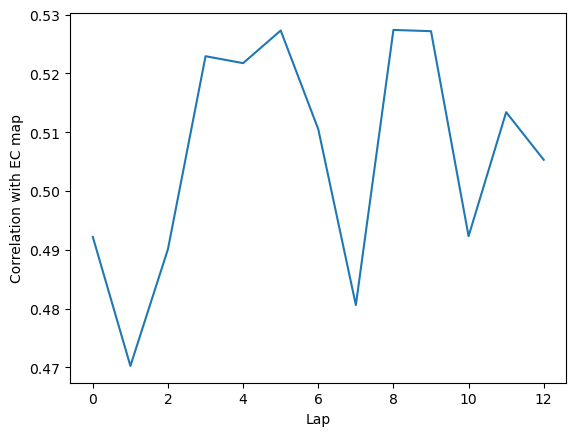

In [18]:
cors = []

for i in range(len(st_idxs) - 1):
    start, stop = st_idxs[i], st_idxs[i + 1]
    event_count_lap = event_count[start:stop, :]
    fr, x_run_reshaped = get_firing_rates(pyramidal, event_count_lap, x_run[start:stop])
    
    mean_firing_rates = get_activation_map(fr, m_EC_orig, x_run_reshaped)
    cors.append(cor_act_maps(EC_act_maps[out], mean_firing_rates))
        
    # pyramidal = plot_burst_collector(pyramidal, out)

plt.figure()
plt.plot(cors)
plt.xlabel('Lap')
plt.ylabel('Correlation with EC map')
plt.show()

In [19]:
print(len(st_idxs))

14


In [20]:
print(st_idxs)

[0, 10739, 20271, 30155, 42471, 55088, 68217, 79560, 89841, 102231, 114604, 125724, 137648, 148474]


In [21]:
for i, j in ENVIRONMENTS_RUNS.items():
    print(i, j)

F2 {'new_env': False, 'top_down': False}
N1 {'new_env': True, 'top_down': False}
F3 {'new_env': False, 'top_down': True}
N2_0 {'new_env': True, 'top_down': True}
N2_1 {'new_env': True, 'top_down': True}
N2_2 {'new_env': True, 'top_down': True}


In [22]:
print(ENVIRONMENTS_RUNS)

{'F2': {'new_env': False, 'top_down': False}, 'N1': {'new_env': True, 'top_down': False}, 'F3': {'new_env': False, 'top_down': True}, 'N2_0': {'new_env': True, 'top_down': True}, 'N2_1': {'new_env': True, 'top_down': True}, 'N2_2': {'new_env': True, 'top_down': True}}
